In [3]:
# Install new analysis env first, needed to add open3d and trimesh

import open3d as o3d
import numpy as np
import trimesh
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D  # noqa
from pathlib import Path

%load_ext autoreload
%autoreload 2

# Uncomment for interactive 3D matplotlib plots, but switching back to 2D plots requires reloading kernel so it's a bit of a hassle
# %matplotlib widget

# ModelNet40

Just a few quick visualizations of the default ModelNet40 data. Expects the following datasets and folders to exist in /datasets/

- ModelNet40: .off files, from https://modelnet.cs.princeton.edu/
- partialmodelnet40: PAPNet .npy files
- pm40_partiality_level: PAPNet .npy files, heavy partiality version
- modelnet40_normal_resampled: Point-Transformers version, either from my Google Drive, Kaggle (https://www.kaggle.com/datasets/chenxaoyu/modelnet-normal-resampled), or the original website but that requires requesting an account: https://shapenet.org/


In [4]:
# Pops up a 3D model view
mesh_path = os.path.join('..', 'datasets', 'ModelNet40', 'airplane', 'train', 'airplane_0001.off')

mesh = o3d.io.read_triangle_mesh(mesh_path)
o3d.visualization.draw_geometries([mesh])

In [3]:
# Can also do this with trimesh without a popup
mesh_path = os.path.join('..', 'datasets', 'ModelNet40', 'airplane', 'train', 'airplane_0002.off')

mesh = trimesh.load(mesh_path)
mesh.show()

In [4]:
mesh

<trimesh.Trimesh(vertices.shape=(44324, 3), faces.shape=(118614, 3))>

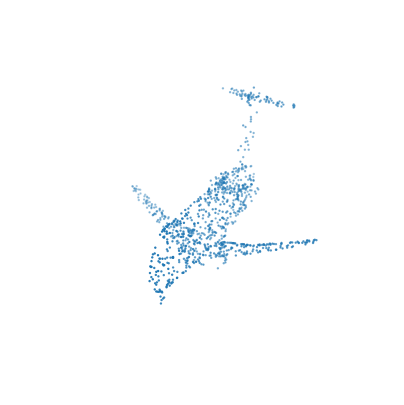

In [5]:
# Sample points from the mesh surface, visualize 2D
mesh_path = '../datasets/ModelNet40/airplane/train/airplane_0003.off'
mesh = trimesh.load(mesh_path)
points = mesh.sample(1024)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.5)
ax.set_axis_off()
plt.show()

# partialmodelnet40

In [6]:
train_points = np.load(os.path.join('..', 'datasets', 'partialmodelnet40', 'train_points.npy'))
print(train_points.shape)
print(type(train_points))

(98430, 1024, 6)
<class 'numpy.ndarray'>


In [ ]:
# Functions to quickly look through a bunch of samples

def visualize_cloud(
    data: np.array,
    i: int,
    ax=None,
    colorbar: bool = False,
    return_sc: bool = False,
    point_size: int = 1
):
    """Visualizes point cloud data with normals in 2D plot.

    Args:
        data (np.array): (n, points, 6) where n=samples, points=point clouds,
            6 = 3 dimensions + 3 normals
        i (int): n index of sample to visualize
        ax (matplotlib.axes, optional): Supply ax if needed.
        colorbar (bool, optional): Adds a colorbar for normals. Defaults False.
        return_sc (bool, optional): Returns the plot or only visualize it.
            Defaults to False. Used for building plots of multiples.
        point_size (int, optional): Point size of visualized points.
            Defaults to 1.

    Returns:
        mpl_toolkits.mplot3d.art3d.Path3DCollection: 3D Plot object.
    """
    sample = data[i]
    points = sample[:, :3]
    normals = sample[:, 3:]

    created_fig = False
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        created_fig = True

    sc = ax.scatter(
        points[:, 0],
        points[:, 1],
        points[:, 2],
        c=normals[:, 2],
        s=point_size,
        cmap='viridis'
    )

    ax.set_box_aspect([1, 1, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    if colorbar and created_fig:
        plt.colorbar(sc, label='Normal Z')

    if return_sc:
        return sc


def visualize_3d(
    data: np.array,
    i: int
):
    """Visualizes point clouds with normals in 3D plot.

    Args:
        data (np.array): (n, points, 6) where n=samples, points=point clouds,
            6 = 3 dimensions + 3 normals
        i (int): n index of sample to visualize
    """
    sample = data[i]
    points = sample[:, :3]
    normals = sample[:, 3:]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals)

    o3d.visualization.draw_geometries([pcd])


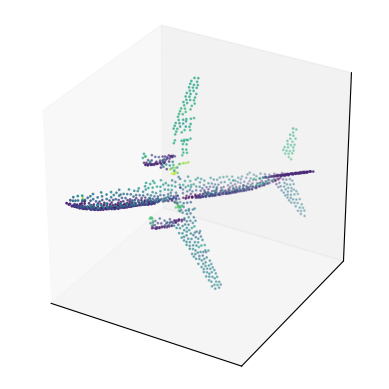

In [8]:
i = 10
visualize_cloud(train_points, i)

In [9]:
visualize_3d(train_points, i)

# PartialModelNet40, Heavy Partiality

In [10]:
train_points_partial40 = np.load(os.path.join('..', 'datasets', 'pm40_partiality_level', 'train_points_40.npy'))
train_points_partial40.shape

(98430, 1024, 6)

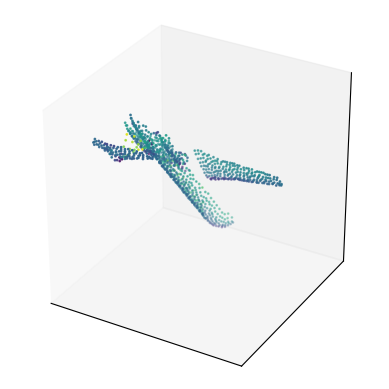

In [11]:
i = 20
visualize_cloud(train_points_partial40, i)

In [18]:
visualize_3d(train_points_partial40, i)

# Multiple Samples

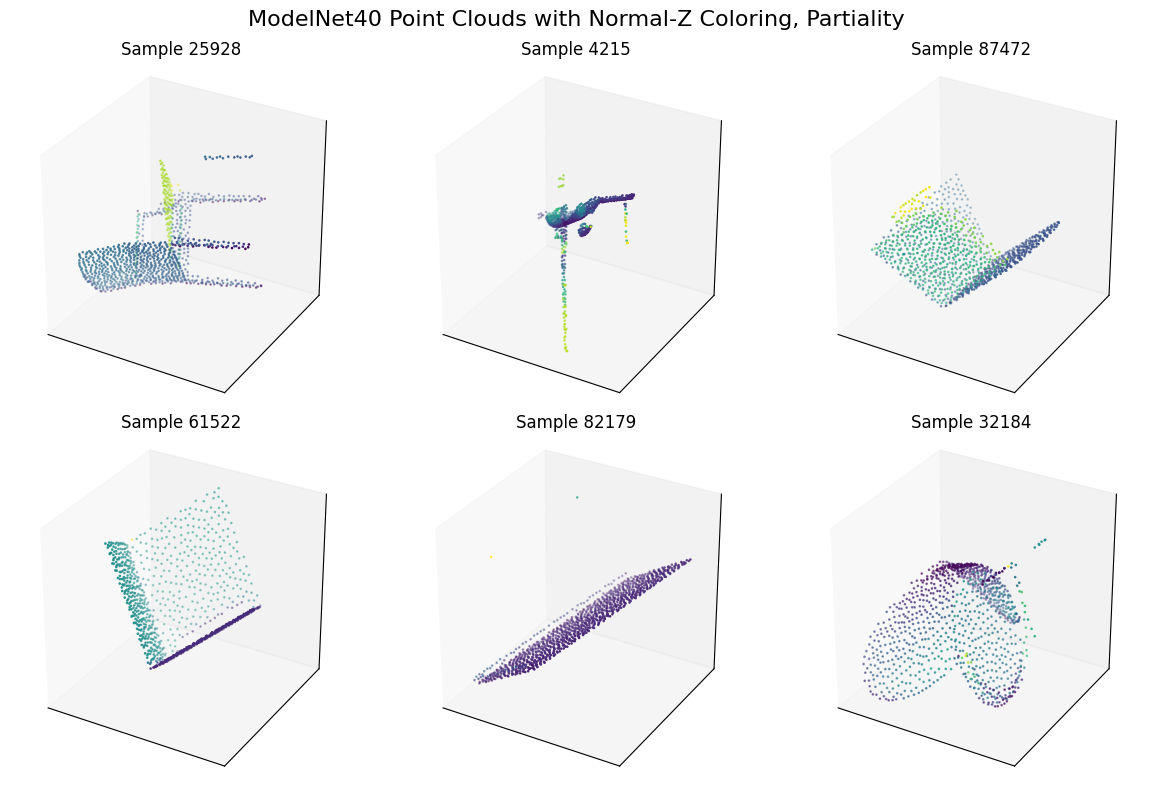

In [16]:
def visualize_samples(
    data: np.array,
    indices: list[int],
    title: str,
    point_size: int = 0.8
):
    fig, axs = plt.subplots(
        2, 3,
        subplot_kw={'projection': '3d'},
        figsize=(12, 8)
    )
    sc = None
    for ax, idx in zip(axs.ravel(), indices):
        sc = visualize_cloud(
            data=data,
            i=idx,
            ax=ax,
            colorbar=False,
            return_sc=True,
            point_size=point_size
        )
        ax.set_title(f'Sample {idx}')

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Gets a bunch of random rows; run again for different samples
indices = np.random.randint(
    low=0,
    high=train_points.shape[0],
    size=6,
    dtype=int
)


visualize_samples(
    data=train_points, 
    indices=indices,
    title='ModelNet40 Point Clouds with Normal-Z Coloring, Partiality'
)

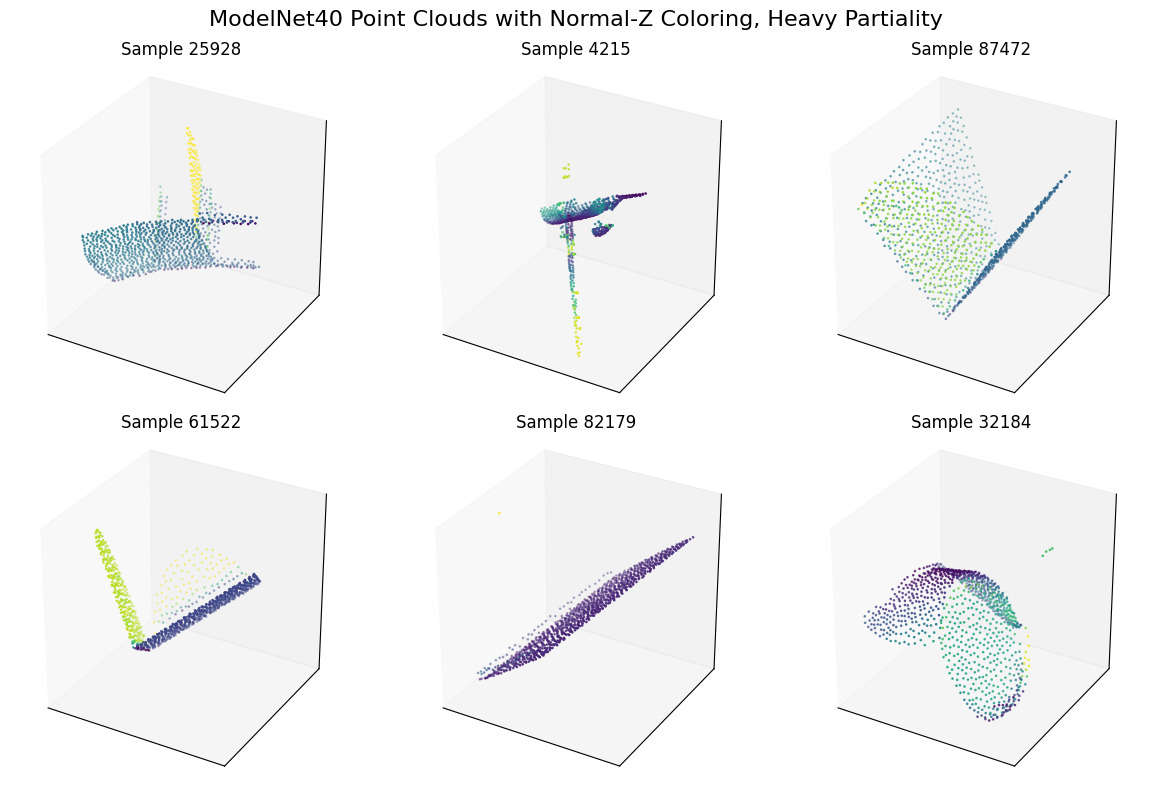

In [17]:
# Using same indices, gets same rows but with stronger partiality
visualize_samples(
    data=train_points_partial40, 
    indices=indices,
    title='ModelNet40 Point Clouds with Normal-Z Coloring, Heavy Partiality'
)

# Modelnet40 Normal Resampled (Point-Transformers data)

In [14]:
# Loads only the airplane folder
folder = Path(os.path.join('..', 'datasets', 'modelnet40_normal_resampled', 'airplane'))
files = sorted(folder.glob('*.txt'))

arrays = []
for f in files:
    arr = np.loadtxt(f, delimiter=',')
    arrays.append(arr)

airplanes = np.stack(arrays, axis=0)
airplanes.shape

(726, 10000, 6)

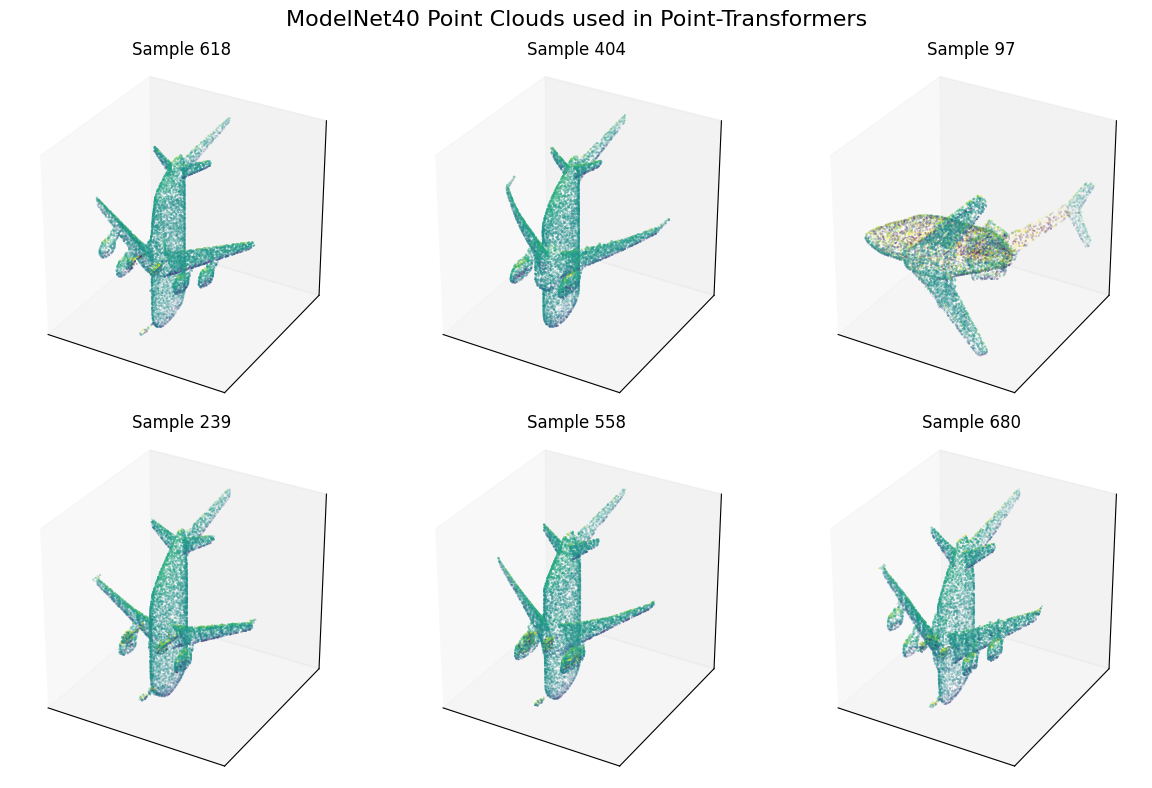

In [15]:
indices = np.random.randint(
    low=0,
    high=airplanes.shape[0],
    size=6,
    dtype=int
)

visualize_samples(
    data=airplanes, 
    indices=indices,
    title='ModelNet40 Point Clouds used in Point-Transformers',
    point_size=0.05
)